Input number of dots and clusters
1000, 3
Calculated with given accuracy, number of iterations = 9


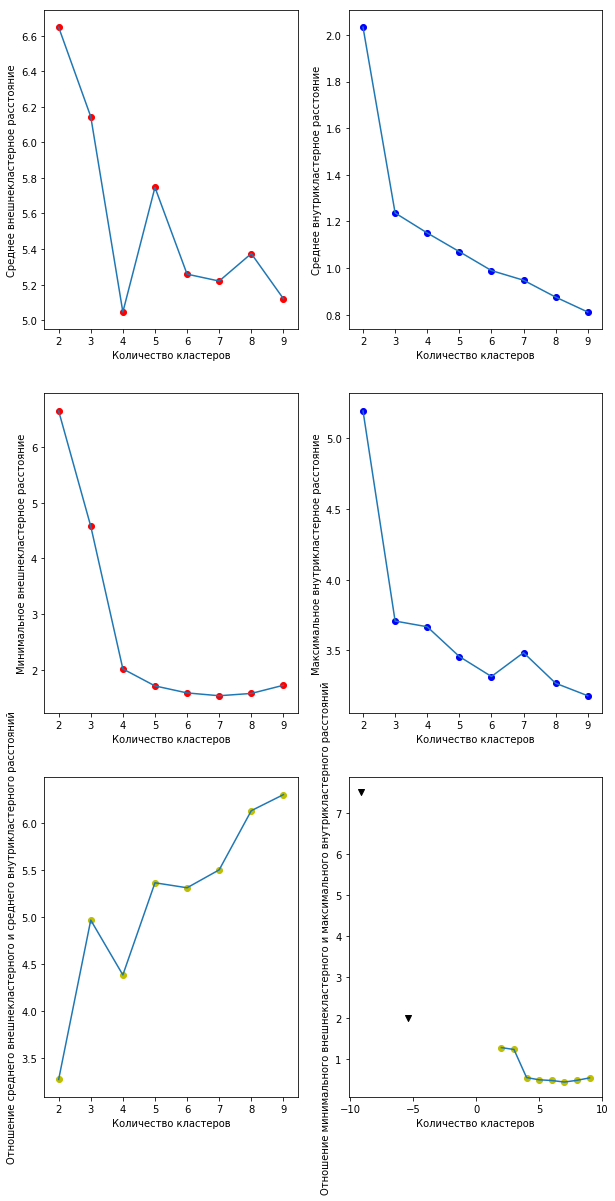

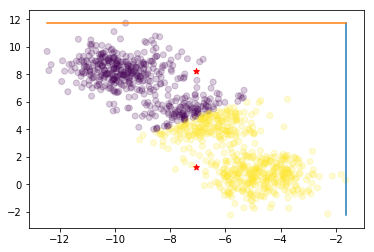

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pylab

def uniform(ratio, k, eps = 1):
    a = int(np.sqrt(k))
    b = k // a + (k % a != 0)
    while abs(a / b - ratio) >= eps:
        if a == 1:
            break
        a -= 1
        b = k // a + (k % a != 0)
    return (a, b)

def dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def strat_of_init(matr, strat = "uniform", k = 2, show_work = -1, eps = 0.0001):
    if k == 0:
        print("k == 0!!!!")
    x = np.asarray(matr[:, 0])
    y = np.asarray(matr[:, 1])
    length = len(x)
    xc = np.zeros(k)
    yc = np.zeros(k)
    
    if strat == "random":
        xc = np.random.rand(k) * (x.max() - x.min()) + x.min()
        yc = np.random.rand(k) * (y.max() - y.min()) + y.min()
        if show_work >= 0:
            pylab.figure(show_work)
            plt.scatter(xc, yc, marker = "*", c = "r")
        return xc, yc
    if strat == "choice":
        r = np.random.choice(length, k, replace = False)
        xc = x[r]
        yc = y[r]
        if show_work >= 0:
            pylab.figure(show_work)
            plt.scatter(xc, yc, marker = "*", c = "r")
        return xc, yc
    x_len = x.max()-x.min()
    y_len = y.max()-y.min()
    uni_x, uni_y = uniform((x_len)/(y_len), k, eps = eps)
    #print(k, uni_x, uni_y)
    units = np.random.choice(uni_x * uni_y, k, replace = False)
    xc = np.zeros(k)
    yc = np.zeros(k)
    for i in range(k):
        xc[i] = x.min() + x_len / (2 * uni_x) + (units[i] % uni_x) * x_len / uni_x
        yc[i] = y.min() + y_len / (2 * uni_y) + (units[i] % uni_y) * y_len / uni_y
    for i in range(uni_x + 1):
        xline = x.min() + i * x_len / uni_x
    for i in range(uni_y + 1):
        yline = y.min() + i * y_len / uni_y
    if show_work >= 0:
        pylab.figure(0)
        plt.scatter(xc, yc, marker = "*", c = "r")
        plt.plot([xline, xline], [y.min(), y.max()])
        plt.plot([x.min(), x.max()], [yline, yline])
    return xc, yc
    

'''
def sort_by_clust(x, k):
    ans = []
    length = x.shape[0]
    x0 = x[:, 0]
    y0 = x[:, 1]
    for i in range(k):
        fil = list(filter(lambda q: x[q][2] == i, range(length)))
        ans = np.concatenate([ans, x0[fil]])
    for i in range(k):
        fil = list(filter(lambda q: x[q][2] == i, range(length)))
        ans = np.concatenate([ans, y0[fil]])
    return ans.reshape(2, length).T
'''
def filter_by_clust(a, i, length):
    return list(filter(lambda q: a[q] == i, range(length)))

def KMeans4(matr, k = 2, seed = 0, eps = 0.0001, limit_of_rec = 500, show_work = -1, strat = "uniform"):
    np.random.seed(seed)
    x = np.asarray(matr[:, 0])
    y = np.asarray(matr[:, 1])
    length = len(x)
    
    xc, yc = strat_of_init(matr, strat = "uniform", k = k, show_work=show_work)
    matr = np.concatenate([x, y, np.random.randint(0, k, length, dtype = int)])
    matr = matr.reshape(3, length).T
    limit = limit_of_rec
    while True:
        limit -= 1
        if limit == 0:
            if show_work >= 0:
                print("Calculated with the achievement of the limit number of iterations: ", limit_of_rec)
            break
        for i in range(length):
            clast = k - 1
            dist_to_clast = dist(matr[i][0], matr[i][1], xc[k - 1], yc[k - 1])
            for j in range(k - 1):
                cur_dist = dist(matr[i][0], matr[i][1], xc[j], yc[j])
                if cur_dist < dist_to_clast:
                    dist_to_clast = cur_dist
                    clast = j
            matr[i][2] = clast
        sums = 0
        for i in range(k):
            fil = filter_by_clust(matr[:, 2], i, length)
            if len(fil) == 0:
                sums = eps + 1
                r = np.random.randint(length)
                xc[i] = x[r]
                yc[i] = y[r]
            else:
                xcc = xc[i]
                ycc = yc[i]
                xc[i] = np.mean(x[fil])
                yc[i] = np.mean(y[fil])
                sums += dist(xc[i], yc[i], xcc, ycc)
        if sums < eps:
            if show_work >= 0:
                print("Calculated with given accuracy, number of iterations =", limit_of_rec - limit)
            break
    if show_work >= 0:
        pylab.figure(show_work)
        plt.scatter(xc, yc, marker = "v", c = "black")
    return (matr[:, 2], xc, yc)

def best_K(matr, k_max = 0, show_work = -1):
    x = np.asarray(matr[:, 0])
    y = np.asarray(matr[:, 1])
    length = len(x)
    if k_max == 0:
        k_max = int(pow(length, 1/3)) + 1
    if k_max < 2:
        k_max = 3
    arr = np.array(range(k_max - 2)) + 2
    inter_mean = np.zeros(k_max - 2)
    exter_mean = np.zeros(k_max - 2)
    inter_max = np.zeros(k_max - 2)
    exter_min = np.zeros(k_max - 2)
    
    for e in range(k_max - 2):
        if arr[e] == 0:
            print("Oh no!")
        a, xc, yc = KMeans4(matr, k = arr[e])
        num_ex = 0
        num_in = 0
        flag = True
        for i in range(arr[e]):
            j = i + 1
            while j < arr[e]:
                d = dist(xc[i], yc[i], xc[j], yc[j])
                exter_mean[e] += d
                num_ex += 1
                if flag:
                    exter_min[e] = d
                    flag = False
                else:
                    exter_min[e] = min(exter_min[e], d)
                j += 1
            fil = filter_by_clust(a, i, length)
            for j in fil:
                d = dist(xc[i], yc[i], x[j], y[j])
                inter_mean[e] += d
                num_in += 1
                #print(e, i, j)
                inter_max[e] = max(inter_max[e], d)
                
        exter_mean[e] /= num_ex
        inter_mean[e] /= num_in
    #print(exter_min)        
    if show_work >= 0:
        pylab.figure(show_work, figsize = (10, 20))
        pylab.subplot(3, 2, 1)
        plt.plot(arr, exter_mean)
        plt.scatter(arr, exter_mean, c = 'r')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Среднее внешнекластерное расстояние")

        pylab.subplot(3, 2, 2)
        plt.plot(arr, inter_mean)
        plt.scatter(arr, inter_mean, c = 'b')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Среднее внутрикластерное расстояние")
        
        pylab.subplot(3, 2, 3)
        plt.plot(arr, exter_min)
        plt.scatter(arr, exter_min, c = 'r')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Минимальное внешнекластерное расстояние")
        
        pylab.subplot(3, 2, 4)
        plt.plot(arr, inter_max)
        plt.scatter(arr, inter_max, c = 'b')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Максимальное внутрикластерное расстояние")
        
        pylab.subplot(3, 2, 5)
        plt.plot(arr, exter_mean/inter_mean)
        plt.scatter(arr, exter_mean/inter_mean, c = 'y')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Отношение среднего внешнекластерного и среднего внутрикластерного расстояний")
        
        pylab.subplot(3, 2, 6)
        plt.plot(arr, exter_min/inter_max)
        plt.scatter(arr, exter_min/inter_max, c = 'y')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Отношение минимального внешнекластерного и максимального внутрикластерного расстояний")
    return arr[(exter_min/inter_max).argmax()]  

n, k = eval(input("Input number of dots and clusters\n"))
x, y = make_blobs(n_samples = n, n_features = 2, centers = k, random_state = 12)
k1 = best_K(x, show_work = 1)
a, b, c = KMeans4(x, k = k1, show_work = True)
pylab.figure(0)
plt.scatter(x[:, 0], x[:, 1], c = a, alpha = 0.2)

plt.show()